Season 12-18:
dfc["threshold"] = 0.05 + 0.25*dfc["martyrdom_scaled"]

Season 19:
0.05 + 0.25*dfc["martyrdom_scaled"] - 0.05*dfc["hypediff"]

Season 20-24: 
0.05 + 0.25*dfc["martyrdom_scaled"] - 0.035*dfc["hypediff"]

In [82]:
import load

df = load.data("groundout_formulas", season=22, roles = ("batter", "fielder", "relevant_runner"))

df = df[df['event_type']=='Sac']

df["martyrdom_scaled"] = load.player_attribute(df, 'batter', 'martyrdom', vibes=False, mods=True, items=True, broken_items=True)
df["martyrdom_test"] = load.player_attribute(df, 'batter', 'martyrdom', vibes=False, mods=False, items=True, broken_items=True)


In [83]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [84]:
#df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)] 
dfc = df.copy()
for exclude_mod in []:
    #dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
#for exclude_mod in []:
    #dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    
#dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

len(dfc)

2788

In [85]:
dfc["hypediff"] = dfc["pitching_team_hype"]  - dfc["batting_team_hype"]

In [ ]:
X = dfc[
    [
        "roll",
        "passed",
        "martyrdom_scaled",
        #"bhype",
        #"phype",
        "hypediff"



    ]
].copy()
#X = X[X["roll"] < 0.85]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.05
pins = [ (0.25, "martyrdom_scaled"), 
(-0.035, "hypediff")

]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[1961    0]
 [   0  827]]
0 outliers
1.0
0.05


[(1.0, 'roll'), (0.030941325448345026, 'hypediff')]

In [94]:

dfc["threshold"] = 0.05 + 0.25*dfc["martyrdom_scaled"] - 0.035*dfc["hypediff"]

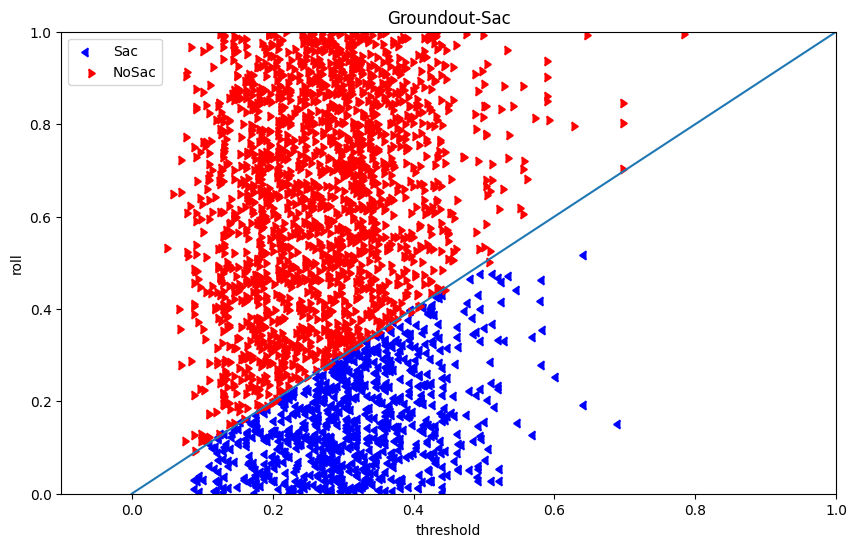

In [95]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Sac", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoSac", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Groundout-Sac")
ax.set_xlim([-0.1, 1])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,event_type,roll,threshold,batting_team_hype,martyrdom_scaled,martyrdom_test,batter_mods,batting_team_mods,batter_name,season,day,game_id,play_count
7608,-0.001313,Sac,0.500978,0.502291,1.02,1.666366,1.388638,HONEY_ROASTED,ELECTRIC;LATE_TO_PARTY;OVERPERFORMING;LIFE_OF_...,Francisca Sasquatch,22,85,eb8e5ad9-8240-4496-9891-cb90d94209e5,154
6888,-0.000850,Sac,0.439876,0.440726,0.63,1.474705,1.017038,SKIPPING;UNCERTAIN,HIGH_PRESSURE;H20;LATE_TO_PARTY;OVERPERFORMING...,Slosh Truk,22,77,dfb4131b-75f3-4624-8c7a-b65942a57cb0,445


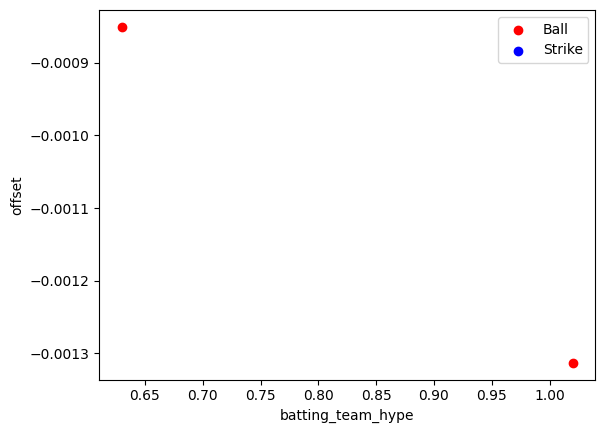

In [96]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["roll"] < 0.85]


fig, ax = plt.subplots(1)
x_val = "batting_team_hype"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold", "batting_team_hype", "martyrdom_scaled", "martyrdom_test", "batter_mods", "batting_team_mods",
       "batter_name", "season",  "day",  "game_id", "play_count"]].sort_values('offset')


In [90]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.5174083096343407
0.0928330759991455
